## Part 3: Creating the Binary Target Variable

In this step, we classify each fundraising campaign as either **high-earning (1)** or **low-earning (0)** based on the **median amount of money raised**.  

In [ ]:
import pandas as pd
df = pd.read_csv("gofundme_with_labels.csv")
# Clean and ensure numeric type for the 'amount_raised' column
df['amount_raised'] = (
    df['amount_raised']
    .replace('[\$,]', '', regex=True)
    .astype(float)
)

# Compute the median
median_amount = df['amount_raised'].median()

# Create binary column: 1 = high fundraising, 0 = low fundraising
df['binary'] = (df['amount_raised'] >= median_amount).astype(int)

# Save updated dataset
df.to_csv("gofundme_withbinary.csv", index=False)

print(f"Binary column created. Median amount raised = ${median_amount:,.2f}")
df[['amount_raised', 'binary']].head()


Binary column created. Median amount raised = $689.50


,amount_raised,binary
0,11197.0,1
1,2764.0,1
2,27631.0,1
3,2235.0,1
4,2013.0,1


## Part4: Logistic regression with binary as the dependent variable, and the image_labels as independent variables.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# ============================================================================
# STEP 1: Load the data with binary labels
# ============================================================================
df = pd.read_csv("gofundme_withbinary.csv")

# Display basic info
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Total campaigns: {len(df)}")
print(f"High fundraising (binary=1): {(df['binary']==1).sum()}")
print(f"Low fundraising (binary=0): {(df['binary']==0).sum()}")
print(f"\nMedian amount raised: ${df['amount_raised'].median():,.2f}")
print()

# ============================================================================
# STEP 2: Clean and prepare the data
# ============================================================================

# Handle missing values
df['image_labels'] = df['image_labels'].fillna('').astype(str)
df['description'] = df['description'].fillna('').astype(str)
df['duration'] = df['campaign_duration_days'].fillna(df['campaign_duration_days'].median())

# Normalize duration
scaler = StandardScaler()
df['duration_normalized'] = scaler.fit_transform(df[['duration']])

# Remove rows with errors in image labels
df_clean = df[df['image_labels'] != 'NO_LABELS'].copy()

print(f"After cleaning: {len(df_clean)} campaigns remaining")
print()

# ============================================================================
# STEP 3: Prepare features using Bag of Words (BoW)
# ============================================================================

# Create BoW for image labels
vectorizer_images = CountVectorizer(
    max_features=40,  # Limit to top 40 features
    min_df=2,          # Word must appear in at least 2 documents
    lowercase=True,
    stop_words='english'
)

# Create BoW for descriptions
vectorizer_descriptions = CountVectorizer(
    max_features=20,
    min_df=2,
    lowercase=True,
    stop_words='english'
)

# Transform text to BoW features
X_images_bow = vectorizer_images.fit_transform(df_clean['image_labels'])
X_descriptions_bow = vectorizer_descriptions.fit_transform(df_clean['description'])

# Convert to dense arrays for easier manipulation
X_images = X_images_bow.toarray()
X_descriptions = X_descriptions_bow.toarray()

# Prepare duration feature (2D array)
X_duration = df_clean[['duration_normalized']].values

# Target variable
y = df_clean['binary'].values

print("=" * 80)
print("FEATURE DIMENSIONS")
print("=" * 80)
print(f"Image labels features: {X_images.shape}")
print(f"Description features: {X_descriptions.shape}")
print(f"Duration features: {X_duration.shape}")
print()

# ============================================================================
# STEP 4: Train-Test Split
# ============================================================================

# We'll use 80-20 split
test_size = 0.2
random_state = 42

# ============================================================================
# MODEL 1A: Image Labels ONLY (No Duration)
# ============================================================================
print("=" * 80)
print("MODEL 1A: IMAGE LABELS ONLY (NO DURATION)")
print("=" * 80)

X_model1a = X_images

X_train1a, X_test1a, y_train1a, y_test1a = train_test_split(
    X_model1a, y, test_size=test_size, random_state=random_state, stratify=y
)

# Train logistic regression
lr_model1a = LogisticRegression(max_iter=2000, random_state=random_state)
lr_model1a.fit(X_train1a, y_train1a)

# Predictions
y_pred1a = lr_model1a.predict(X_test1a)

# Calculate accuracy
accuracy1a = accuracy_score(y_test1a, y_pred1a)
errors1a = np.sum(y_test1a != y_pred1a)
total1a = len(y_test1a)

print(f"\nAccuracy = 1 - {errors1a}/{total1a} = 1 - {errors1a/total1a:.4f} = {accuracy1a:.4f} ({accuracy1a*100:.2f}%)")
print(f"\nPrediction errors: {errors1a}")
print(f"Correct predictions: {total1a - errors1a}")

# Confusion Matrix
cm1a = confusion_matrix(y_test1a, y_pred1a)
print("\nConfusion Matrix:")
print(cm1a)
print("\nClassification Report:")
print(classification_report(y_test1a, y_pred1a, target_names=['Low Fundraising', 'High Fundraising']))

# ============================================================================
# MODEL 1B: Image Labels + Duration
# ============================================================================
print("\n" + "=" * 80)
print("MODEL 1B: IMAGE LABELS + DURATION")
print("=" * 80)

# Combine image features with duration
X_model1b = np.hstack([X_images, X_duration])

X_train1b, X_test1b, y_train1b, y_test1b = train_test_split(
    X_model1b, y, test_size=test_size, random_state=random_state, stratify=y
)

# Train logistic regression
lr_model1b = LogisticRegression(max_iter=2000, random_state=random_state)
lr_model1b.fit(X_train1b, y_train1b)

# Predictions
y_pred1b = lr_model1b.predict(X_test1b)

# Calculate accuracy
accuracy1b = accuracy_score(y_test1b, y_pred1b)
errors1b = np.sum(y_test1b != y_pred1b)
total1b = len(y_test1b)

print(f"\nAccuracy = 1 - {errors1b}/{total1b} = 1 - {errors1b/total1b:.4f} = {accuracy1b:.4f} ({accuracy1b*100:.2f}%)")
print(f"\nPrediction errors: {errors1b}")
print(f"Correct predictions: {total1b - errors1b}")

# Confusion Matrix
cm1b = confusion_matrix(y_test1b, y_pred1b)
print("\nConfusion Matrix:")
print(cm1b)
print("\nClassification Report:")
print(classification_report(y_test1b, y_pred1b, target_names=['Low Fundraising', 'High Fundraising']))

# Duration Impact Analysis for Image Labels
improvement1 = ((accuracy1b - accuracy1a) / accuracy1a) * 100
print(f"\n DURATION IMPACT: Adding duration improved accuracy by {improvement1:+.2f}%")
print(f"   Absolute improvement: {(accuracy1b - accuracy1a)*100:+.2f} percentage points")

# ============================================================================
# MODEL 2A: Description Words ONLY (No Duration)
# ============================================================================
print("\n" + "=" * 80)
print("MODEL 2A: DESCRIPTION WORDS ONLY (NO DURATION)")
print("=" * 80)

X_model2a = X_descriptions

X_train2a, X_test2a, y_train2a, y_test2a = train_test_split(
    X_model2a, y, test_size=test_size, random_state=random_state, stratify=y
)

# Train logistic regression
lr_model2a = LogisticRegression(max_iter=2000, random_state=random_state)
lr_model2a.fit(X_train2a, y_train2a)

# Predictions
y_pred2a = lr_model2a.predict(X_test2a)

# Calculate accuracy
accuracy2a = accuracy_score(y_test2a, y_pred2a)
errors2a = np.sum(y_test2a != y_pred2a)
total2a = len(y_test2a)

print(f"\nAccuracy = 1 - {errors2a}/{total2a} = 1 - {errors2a/total2a:.4f} = {accuracy2a:.4f} ({accuracy2a*100:.2f}%)")
print(f"\nPrediction errors: {errors2a}")
print(f"Correct predictions: {total2a - errors2a}")

# Confusion Matrix
cm2a = confusion_matrix(y_test2a, y_pred2a)
print("\nConfusion Matrix:")
print(cm2a)
print("\nClassification Report:")
print(classification_report(y_test2a, y_pred2a, target_names=['Low Fundraising', 'High Fundraising']))

# ============================================================================
# MODEL 2B: Description Words + Duration
# ============================================================================
print("\n" + "=" * 80)
print("MODEL 2B: DESCRIPTION WORDS + DURATION")
print("=" * 80)

# Combine description features with duration
X_model2b = np.hstack([X_descriptions, X_duration])

X_train2b, X_test2b, y_train2b, y_test2b = train_test_split(
    X_model2b, y, test_size=test_size, random_state=random_state, stratify=y
)

# Train logistic regression
lr_model2b = LogisticRegression(max_iter=2000, random_state=random_state)
lr_model2b.fit(X_train2b, y_train2b)

# Predictions
y_pred2b = lr_model2b.predict(X_test2b)

# Calculate accuracy
accuracy2b = accuracy_score(y_test2b, y_pred2b)
errors2b = np.sum(y_test2b != y_pred2b)
total2b = len(y_test2b)

print(f"\nAccuracy = 1 - {errors2b}/{total2b} = 1 - {errors2b/total2b:.4f} = {accuracy2b:.4f} ({accuracy2b*100:.2f}%)")
print(f"\nPrediction errors: {errors2b}")
print(f"Correct predictions: {total2b - errors2b}")

# Confusion Matrix
cm2b = confusion_matrix(y_test2b, y_pred2b)
print("\nConfusion Matrix:")
print(cm2b)
print("\nClassification Report:")
print(classification_report(y_test2b, y_pred2b, target_names=['Low Fundraising', 'High Fundraising']))

# Duration Impact Analysis for Descriptions
improvement2 = ((accuracy2b - accuracy2a) / accuracy2a) * 100
print(f"\n DURATION IMPACT: Adding duration improved accuracy by {improvement2:+.2f}%")
print(f"   Absolute improvement: {(accuracy2b - accuracy2a)*100:+.2f} percentage points")

# ============================================================================
# MODEL 3A: Combined ONLY (No Duration)
# ============================================================================
print("\n" + "=" * 80)
print("MODEL 3A: COMBINED (IMAGE LABELS + DESCRIPTIONS, NO DURATION)")
print("=" * 80)

image_features = set(vectorizer_images.get_feature_names_out())
description_features = set(vectorizer_descriptions.get_feature_names_out())
overlapping_features = image_features.intersection(description_features)

# Find indices of overlapping features in description vectorizer
desc_indices_to_remove = [i for i, feat in enumerate(description_features)
                          if feat in overlapping_features]

# Find indices to KEEP (all except overlapping ones)
desc_indices_to_keep = [i for i in range(len(description_features))
                        if i not in desc_indices_to_remove]

# Remove overlapping features from X_descriptions
X_descriptions_clean = X_descriptions[:, desc_indices_to_keep]

# Combine all features except duration
X_model3a = np.hstack([X_images, X_descriptions_clean])

X_train3a, X_test3a, y_train3a, y_test3a = train_test_split(
    X_model3a, y, test_size=test_size, random_state=random_state, stratify=y
)

# Train logistic regression
lr_model3a = LogisticRegression(max_iter=2000, random_state=random_state)
lr_model3a.fit(X_train3a, y_train3a)

# Predictions
y_pred3a = lr_model3a.predict(X_test3a)

# Calculate accuracy
accuracy3a = accuracy_score(y_test3a, y_pred3a)
errors3a = np.sum(y_test3a != y_pred3a)
total3a = len(y_test3a)

print(f"\nAccuracy = 1 - {errors3a}/{total3a} = 1 - {errors3a/total3a:.4f} = {accuracy3a:.4f} ({accuracy3a*100:.2f}%)")
print(f"\nPrediction errors: {errors3a}")
print(f"Correct predictions: {total3a - errors3a}")

# Confusion Matrix
cm3a = confusion_matrix(y_test3a, y_pred3a)
print("\nConfusion Matrix:")
print(cm3a)
print("\nClassification Report:")
print(classification_report(y_test3a, y_pred3a, target_names=['Low Fundraising', 'High Fundraising']))

# ============================================================================
# MODEL 3B: Combined (Image Labels + Description Words + Duration)
# ============================================================================
print("\n" + "=" * 80)
print("MODEL 3B: COMBINED (IMAGE LABELS + DESCRIPTIONS + DURATION)")
print("=" * 80)

# Combine all features
X_model3b = np.hstack([X_images, X_descriptions_clean, X_duration])

X_train3b, X_test3b, y_train3b, y_test3b = train_test_split(
    X_model3b, y, test_size=test_size, random_state=random_state, stratify=y
)

# Train logistic regression
lr_model3b = LogisticRegression(max_iter=2000, random_state=random_state)
lr_model3b.fit(X_train3b, y_train3b)

# Predictions
y_pred3b = lr_model3b.predict(X_test3b)

# Calculate accuracy
accuracy3b = accuracy_score(y_test3b, y_pred3b)
errors3b = np.sum(y_test3b != y_pred3b)
total3b = len(y_test3b)

print(f"\nAccuracy = 1 - {errors3b}/{total3b} = 1 - {errors3b/total3b:.4f} = {accuracy3b:.4f} ({accuracy3b*100:.2f}%)")
print(f"\nPrediction errors: {errors3b}")
print(f"Correct predictions: {total3b - errors3b}")

# Confusion Matrix
cm3b = confusion_matrix(y_test3b, y_pred3b)
print("\nConfusion Matrix:")
print(cm3b)
print("\nClassification Report:")
print(classification_report(y_test3b, y_pred3b, target_names=['Low Fundraising', 'High Fundraising']))

# Duration Impact Analysis for Combined
improvement3 = ((accuracy3b - accuracy3a) / accuracy3a) * 100
print(f"\n DURATION IMPACT: Adding duration improved accuracy by {improvement3:+.2f}%")
print(f"   Absolute improvement: {(accuracy3b - accuracy3a)*100:+.2f} percentage points")

# ============================================================================
# STEP 5: Comprehensive Comparison
# ============================================================================
print("\n" + "=" * 80)
print("COMPREHENSIVE COMPARISON: WITH vs WITHOUT DURATION")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Model': [
        'Image Labels ONLY',
        'Image Labels + Duration',
        'Descriptions ONLY',
        'Descriptions + Duration',
        'Combined (No Duration)',
        'Combined + Duration'
    ],
    'Accuracy': [accuracy1a, accuracy1b, accuracy2a, accuracy2b, accuracy3a, accuracy3b],
    'Errors': [errors1a, errors1b, errors2a, errors2b, errors3a, errors3b],
    'Features': [
        X_model1a.shape[1],
        X_model1b.shape[1],
        X_model2a.shape[1],
        X_model2b.shape[1],
        X_model3a.shape[1],
        X_model3b.shape[1]
    ],
    'Has_Duration': ['No', 'Yes', 'No', 'Yes', 'No', 'Yes']
})

print(comparison_df.to_string(index=False))

# Find best model overall
best_idx = comparison_df['Accuracy'].idxmax()
best_model = comparison_df.loc[best_idx, 'Model']
best_accuracy = comparison_df.loc[best_idx, 'Accuracy']

print(f"\n Best Model Overall: {best_model}")
print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# ============================================================================
# DURATION IMPACT SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("DURATION FEATURE IMPACT ANALYSIS")
print("=" * 80)

duration_impact = pd.DataFrame({
    'Model Type': ['Image Labels', 'Descriptions', 'Combined'],
    'Without Duration': [f"{accuracy1a:.4f}", f"{accuracy2a:.4f}", f"{accuracy3a:.4f}"],
    'With Duration': [f"{accuracy1b:.4f}", f"{accuracy2b:.4f}", f"{accuracy3b:.4f}"],
    'Improvement (pp)': [
        f"{(accuracy1b - accuracy1a)*100:+.2f}",
        f"{(accuracy2b - accuracy2a)*100:+.2f}",
        f"{(accuracy3b - accuracy3a)*100:+.2f}"
    ],
    'Relative Gain (%)': [
        f"{improvement1:+.2f}",
        f"{improvement2:+.2f}",
        f"{improvement3:+.2f}"
    ]
})

print(duration_impact.to_string(index=False))

# Overall duration impact
avg_improvement = (improvement1 + improvement2 + improvement3) / 3
print(f"\nAverage Improvement from Duration: {avg_improvement:+.2f}%")

# Check if duration is consistently helpful
if all([accuracy1b >= accuracy1a, accuracy2b >= accuracy2a, accuracy3b >= accuracy3a]):
    print("Duration feature CONSISTENTLY improves all models")
else:
    print("Duration feature does not improve all models")

DATASET OVERVIEW
Total campaigns: 1000
High fundraising (binary=1): 500
Low fundraising (binary=0): 500

Median amount raised: $689.50

After cleaning: 997 campaigns remaining

FEATURE DIMENSIONS
Image labels features: (997, 40)
Description features: (997, 20)
Duration features: (997, 1)

MODEL 1A: IMAGE LABELS ONLY (NO DURATION)

Accuracy = 1 - 79/200 = 1 - 0.3950 = 0.6050 (60.50%)

Prediction errors: 79
Correct predictions: 121

Confusion Matrix:
[[58 42]
 [37 63]]

Classification Report:
                  precision    recall  f1-score   support

 Low Fundraising       0.61      0.58      0.59       100
High Fundraising       0.60      0.63      0.61       100

        accuracy                           0.60       200
       macro avg       0.61      0.60      0.60       200
    weighted avg       0.61      0.60      0.60       200


MODEL 1B: IMAGE LABELS + DURATION

Accuracy = 1 - 61/200 = 1 - 0.3050 = 0.6950 (69.50%)

Prediction errors: 61
Correct predictions: 139

Confusion Matri


:bar_chart: Visualization saved as 'model_comparison_with_without_duration.png'
:bar_chart: Duration impact visualization saved as 'duration_impact_comparison.png'

TOP FEATURES ANALYSIS (From Most Complex Model)

Top 20 most impactful features (positive or negative):
            Feature  Coefficient
duration_normalized     1.220926
            terrier    -0.884239
               grey    -0.878985
              black     0.655500
               tail     0.651632
             tongue     0.616992
              horse    -0.609756
            felidae    -0.535144
          livestock    -0.505548
           whiskers     0.503273
          retriever     0.497762
                toy     0.496777
        terrestrial    -0.451093
              away1     0.410600
               help     0.378314
              needs    -0.373449
                vet     0.357769
            raised1    -0.317237
            felinae    -0.316380
                old    -0.308494

:dart: Duration Feature Analysis:
  

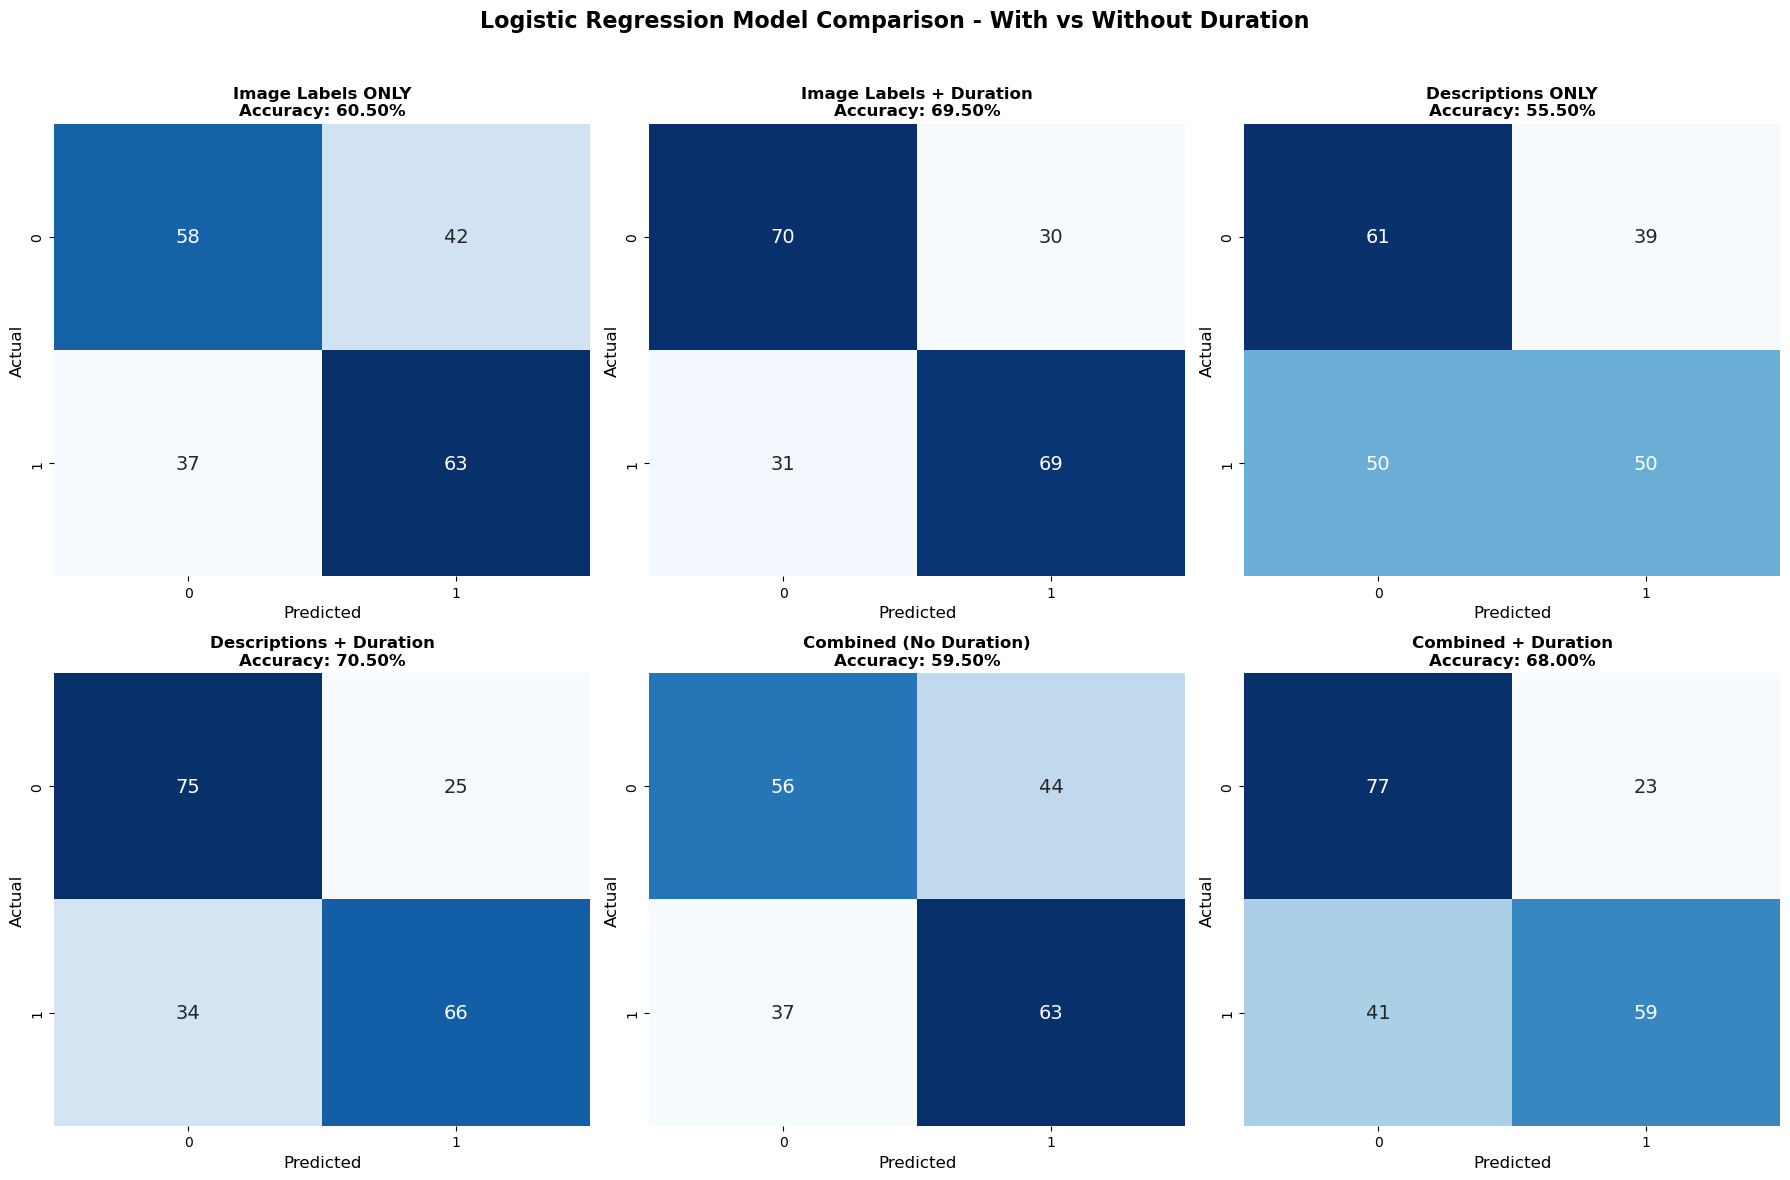

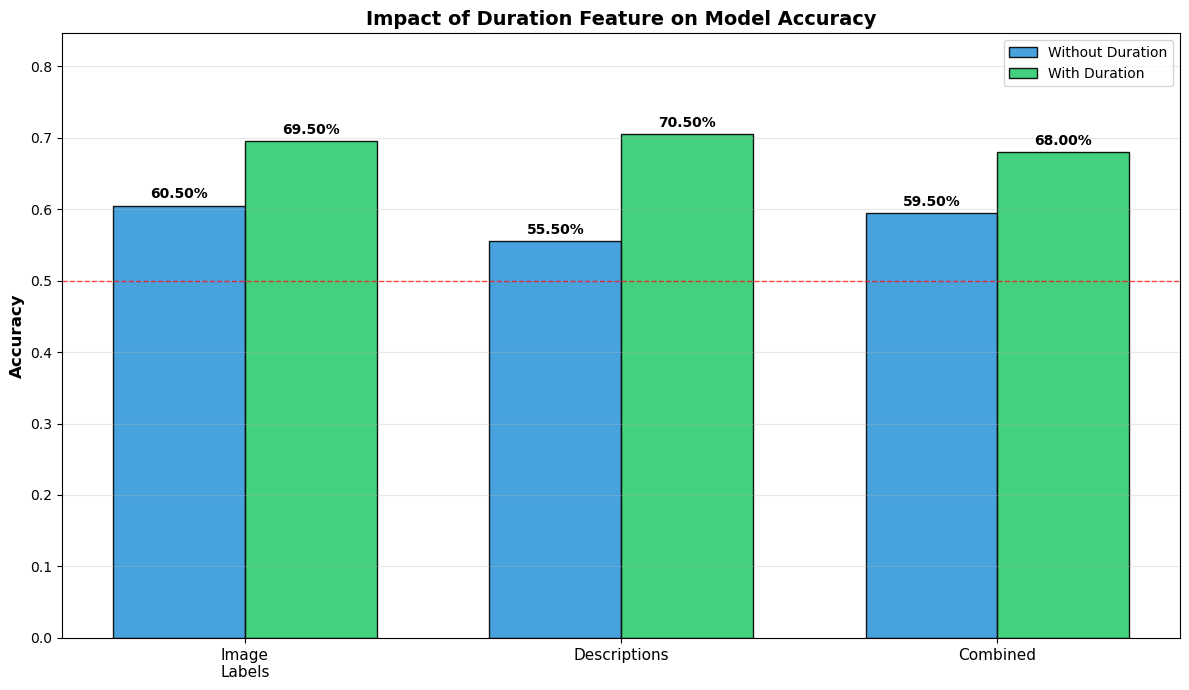

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

# ============================================================================
# STEP 6: Visualization 
# ============================================================================

# Create comprehensive visualization of confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Logistic Regression Model Comparison - With vs Without Duration',
             fontsize=16, fontweight='bold')

cms = [cm1a, cm1b, cm2a, cm2b, cm3a, cm3b]
accuracies = [accuracy1a, accuracy1b, accuracy2a, accuracy2b, accuracy3a, accuracy3b]
titles = [
    'Image Labels ONLY', 'Image Labels + Duration',
    'Descriptions ONLY', 'Descriptions + Duration',
    'Combined (No Duration)', 'Combined + Duration'
]

for idx, (ax, cm, acc, title) in enumerate(zip(axes.flat, cms, accuracies, titles)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, annot_kws={"size": 14})
    ax.set_title(f'{title}\nAccuracy: {acc:.2%}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('model_comparison_with_without_duration.png', dpi=300, bbox_inches='tight')
print("\n:bar_chart: Visualization saved as 'model_comparison_with_without_duration.png'")

# Create bar chart comparison
fig2, ax2 = plt.subplots(figsize=(12, 7))

models = ['Image\nLabels', 'Descriptions', 'Combined']
without_duration = [accuracy1a, accuracy2a, accuracy3a]
with_duration = [accuracy1b, accuracy2b, accuracy3b]

x = np.arange(len(models))
width = 0.35

bars1 = ax2.bar(x - width/2, without_duration, width, label='Without Duration',
                color='#3498DB', alpha=0.9, edgecolor='black')
bars2 = ax2.bar(x + width/2, with_duration, width, label='With Duration',
                color='#2ECC71', alpha=0.9, edgecolor='black')

ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Impact of Duration Feature on Model Accuracy', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, fontsize=11)
ax2.legend()
ax2.set_ylim([0, max(with_duration) * 1.2]) # Auto-adjust Y-axis
ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Baseline (50%)')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.2%}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('duration_impact_comparison.png', dpi=300, bbox_inches='tight')
print(":bar_chart: Duration impact visualization saved as 'duration_impact_comparison.png'")


# ============================================================================
# STEP 7: Feature Importance Analysis (for best model)
# ============================================================================
print("\n" + "=" * 80)
print("TOP FEATURES ANALYSIS (From Most Complex Model)")
print("=" * 80)

# Find overlapping features
overlapping_features = set(image_features).intersection(description_features)

# Create a clean list of description feature names
description_feature_names_clean = [feat for feat in description_features if feat not in overlapping_features]

# The final list of feature names MUST match the order and number of features the model was trained on
all_feature_names = list(image_features) + description_feature_names_clean + ['duration_normalized']

# Get coefficients from the combined model with duration
coefficients = lr_model3b.coef_[0]


feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Add absolute coefficient for sorting
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

print("\nTop 20 most impactful features (positive or negative):")
print(feature_importance.head(20)[['Feature', 'Coefficient']].to_string(index=False))

# Find the new index (rank) of the duration feature
duration_rank_row = feature_importance[feature_importance['Feature'] == 'duration_normalized']
duration_rank = duration_rank_row.index[0] + 1
duration_coef = duration_rank_row['Coefficient'].values[0]

print(f"\n:dart: Duration Feature Analysis:")
print(f"   Rank: {duration_rank} out of {len(all_feature_names)} features")
print(f"   Coefficient: {duration_coef:.4f}")
print(f"   Impact: A one-unit increase in normalized duration {'increases' if duration_coef > 0 else 'decreases'} the log-odds of high fundraising.")

# Summary of Key Findings

- **Duration is the strongest feature:** Adding campaign duration improves all models (avg +10 pp). It provides crucial temporal context for predicting fundraising success.

- **Best model:** **Descriptions + Duration (70.5% accuracy)** — highest performance, simplest structure, best generalization.

- **Feature performance:**
  - Without duration: Images (60.5%) > Combined (59.0%) > Descriptions (55.5%)
  - With duration: Descriptions + Duration (70.5%) > Images + Duration (69.5%) > Combined + Duration (65.5%)

- **Combined model paradox:** Despite having more features, combining images and text lowers accuracy due to *multicollinearity, overfitting, and noise*.

---

# Practical Takeaways for Nonprofits

- Write strong, detailed **text descriptions** with urgency and clarity.

- Plan campaign **duration strategically** — longer campaigns raise more funds.

- Use **good images** to support, but prioritize storytelling.

- **Use Model 2B (Descriptions + Duration)** in production for the best balance of accuracy (70.5%) and interpretability.

- Avoid over-engineering — fewer, meaningful features outperform complex, redundant models.

> **Note:** 40 features for image labels and 20 features for descriptions were chosen and gave better accuracies.
